In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import collections
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.cluster import hierarchy
from scipy.spatial import distance
from features import categorical_features, skewed_features, unskewed_features, cols_idxs

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

Work around PowerTransformer bug: 
https://github.com/scikit-learn/scikit-learn/issues/14959

In [3]:
pt = PowerTransformer()
pt.fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [4]:
# workaround according to https://github.com/scikit-learn/scikit-learn/issues/14959
# apply StandardScaler(with_std=False)
preprocessor = make_pipeline(
    StandardScaler(with_std=False),
    PowerTransformer(standardize=True),
)
preprocessor.fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

array([[ 1.33453279],
       [ 0.48119188],
       [ 0.85696096],
       ...,
       [-1.50537684],
       [-0.98988697],
       [-1.61157313]])

In [5]:
df["per_capita_tax_income"] = StandardScaler(with_std=False).fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

## Distribution of features

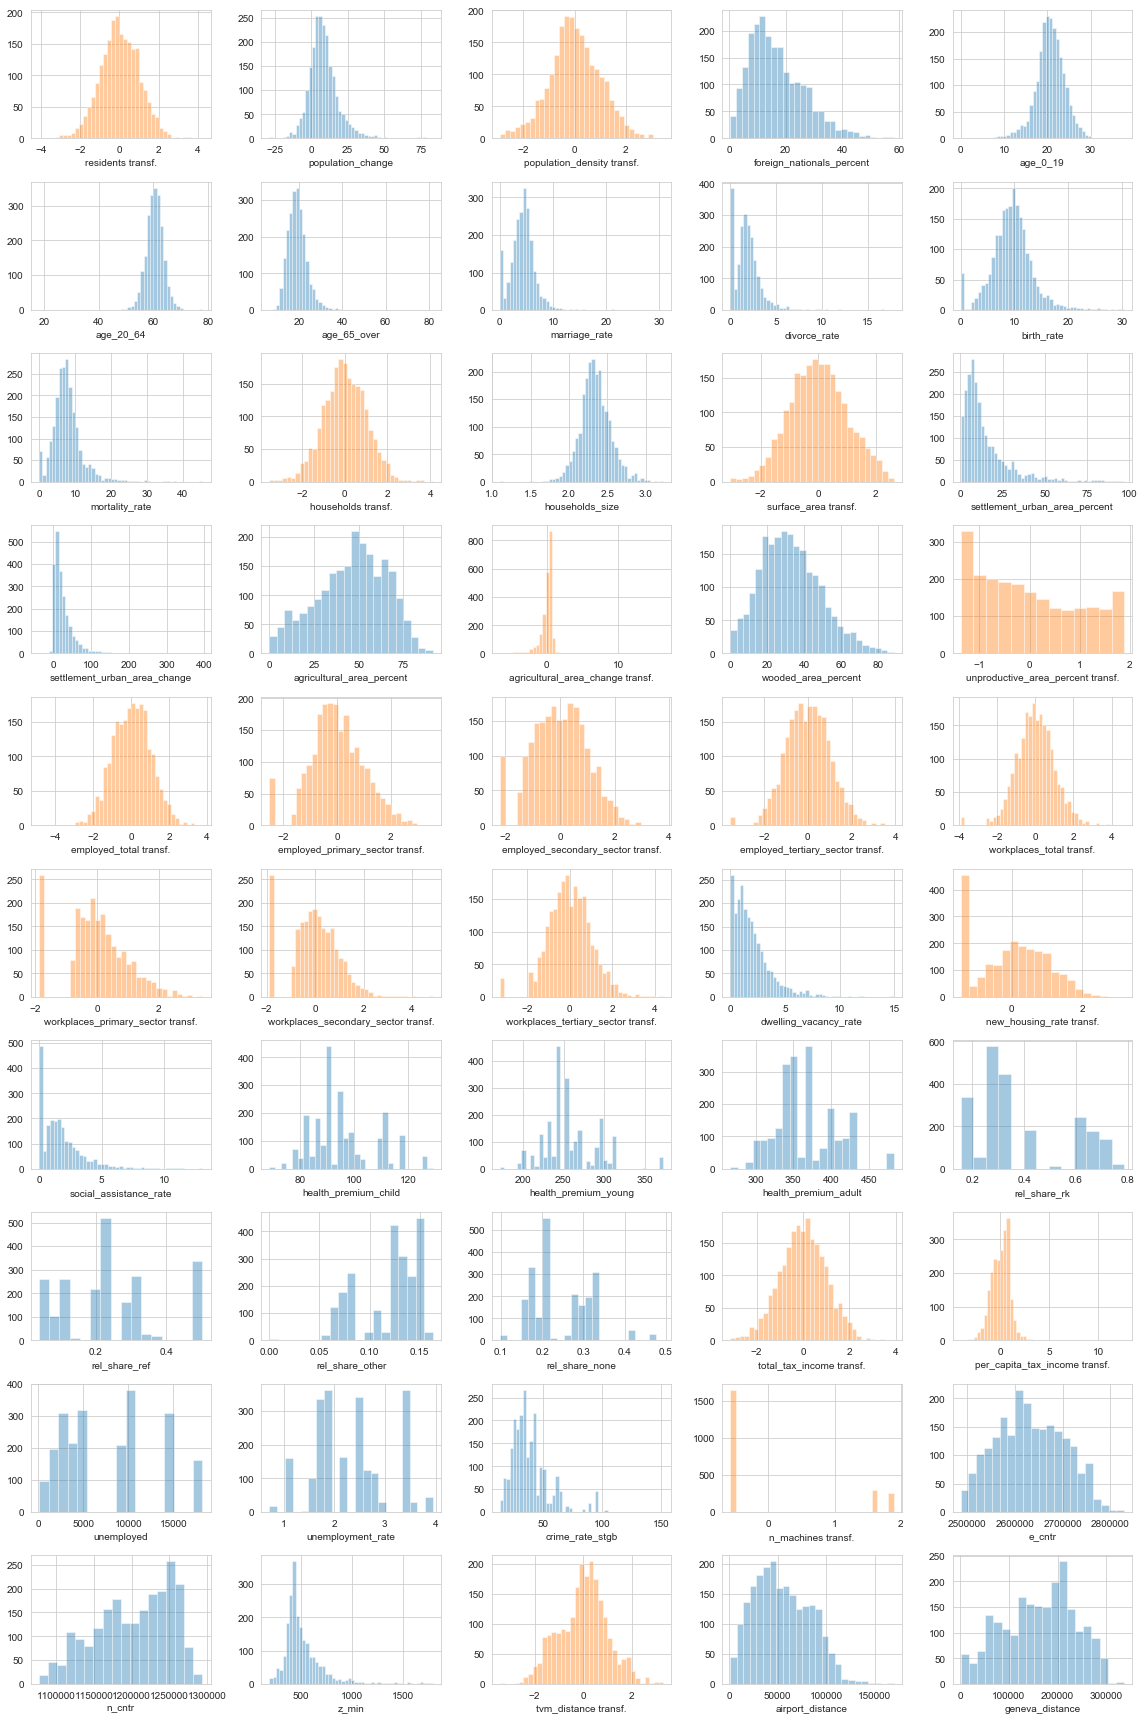

In [6]:
cols = [col for col in df.columns if col not in categorical_features and col != "po_value"]
pt = PowerTransformer()
sns.set_style('whitegrid')
color_0 = sns.color_palette()[0]
color_1 = sns.color_palette()[1]
fig, axs = plt.subplots(10, 5, figsize = (16, 24))
for i, ax in enumerate(axs.flatten()):
    if i < len(cols):
        if cols[i] in unskewed_features:
            sns.distplot(df[cols[i]], kde = False, ax = ax, color=color_0)
        else:
            sns.distplot(pt.fit_transform(df[cols[i]].values.reshape(-1, 1)),
                         kde = False, ax = ax, color=color_1, axlabel=cols[i] + " transf.")
    else:
        ax.set_axis_off()
plt.tight_layout()

## Correlation
With transformed features

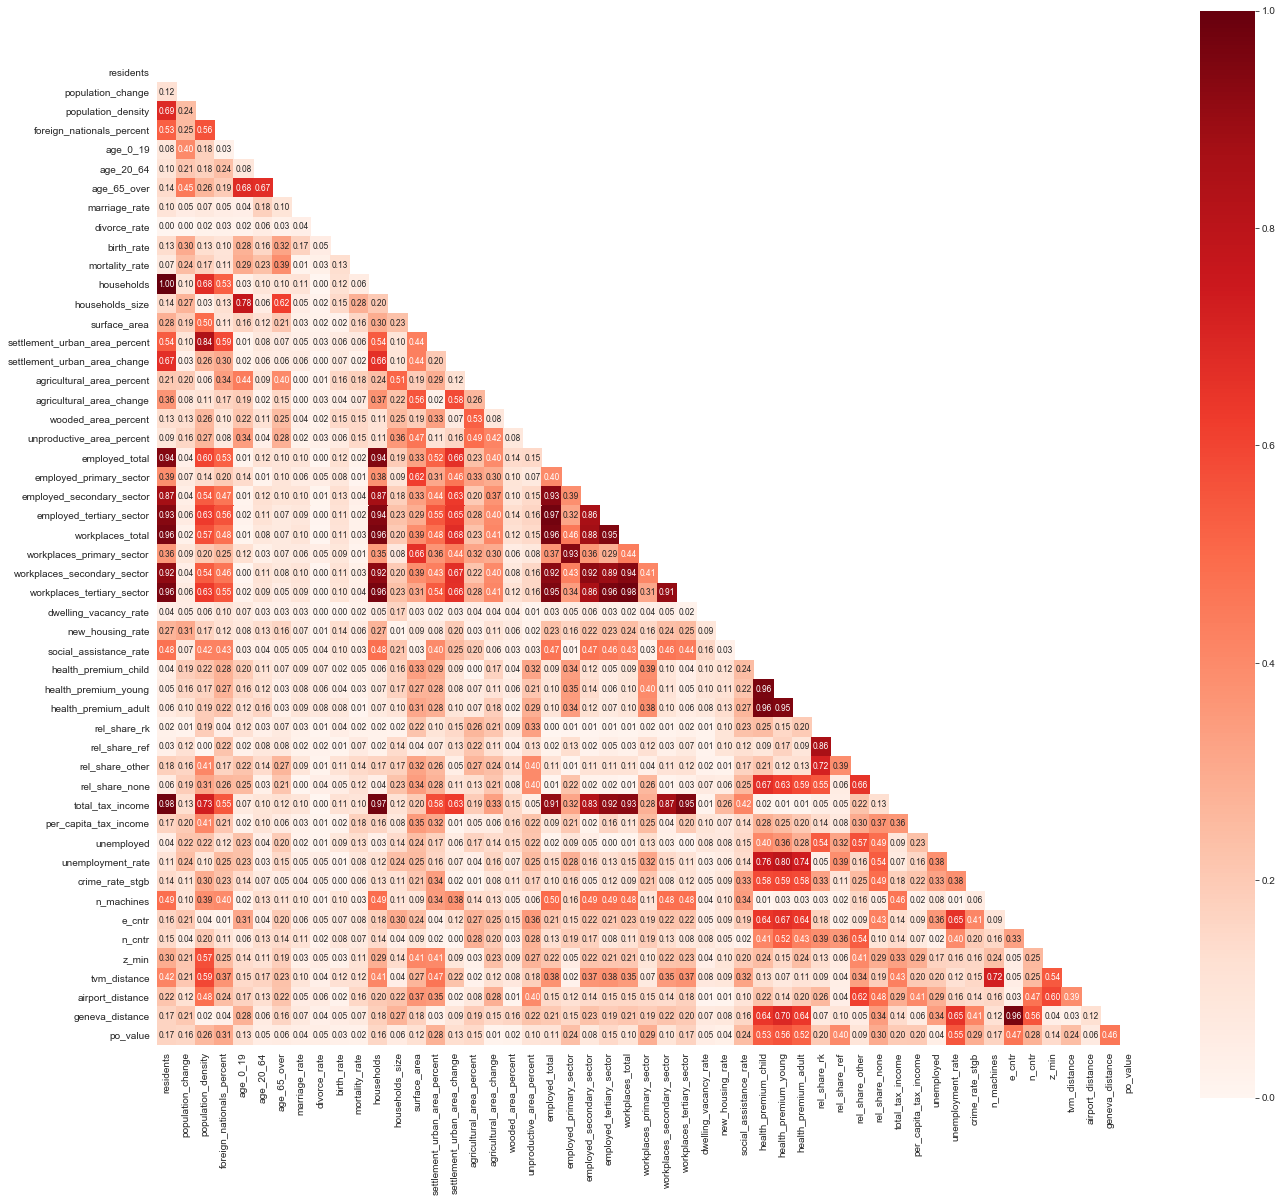

In [7]:
df2 = df.drop(columns=categorical_features)
po_values = df2["po_value"]
df2.drop(columns="po_value", inplace=True)
df2["po_value"] = po_values
pt = PowerTransformer()
for col in skewed_features:
    df2[col] = pt.fit_transform(df2[col].values.reshape(-1, 1))
corr = np.abs(df2.corr())

plt.figure(figsize = (22,20))
sns.heatmap(corr, annot = True, fmt = '.2f',
            square=True, vmin = 0, vmax = 1, cmap= 'Reds', mask = np.triu(corr), annot_kws = {"fontsize":"small"});

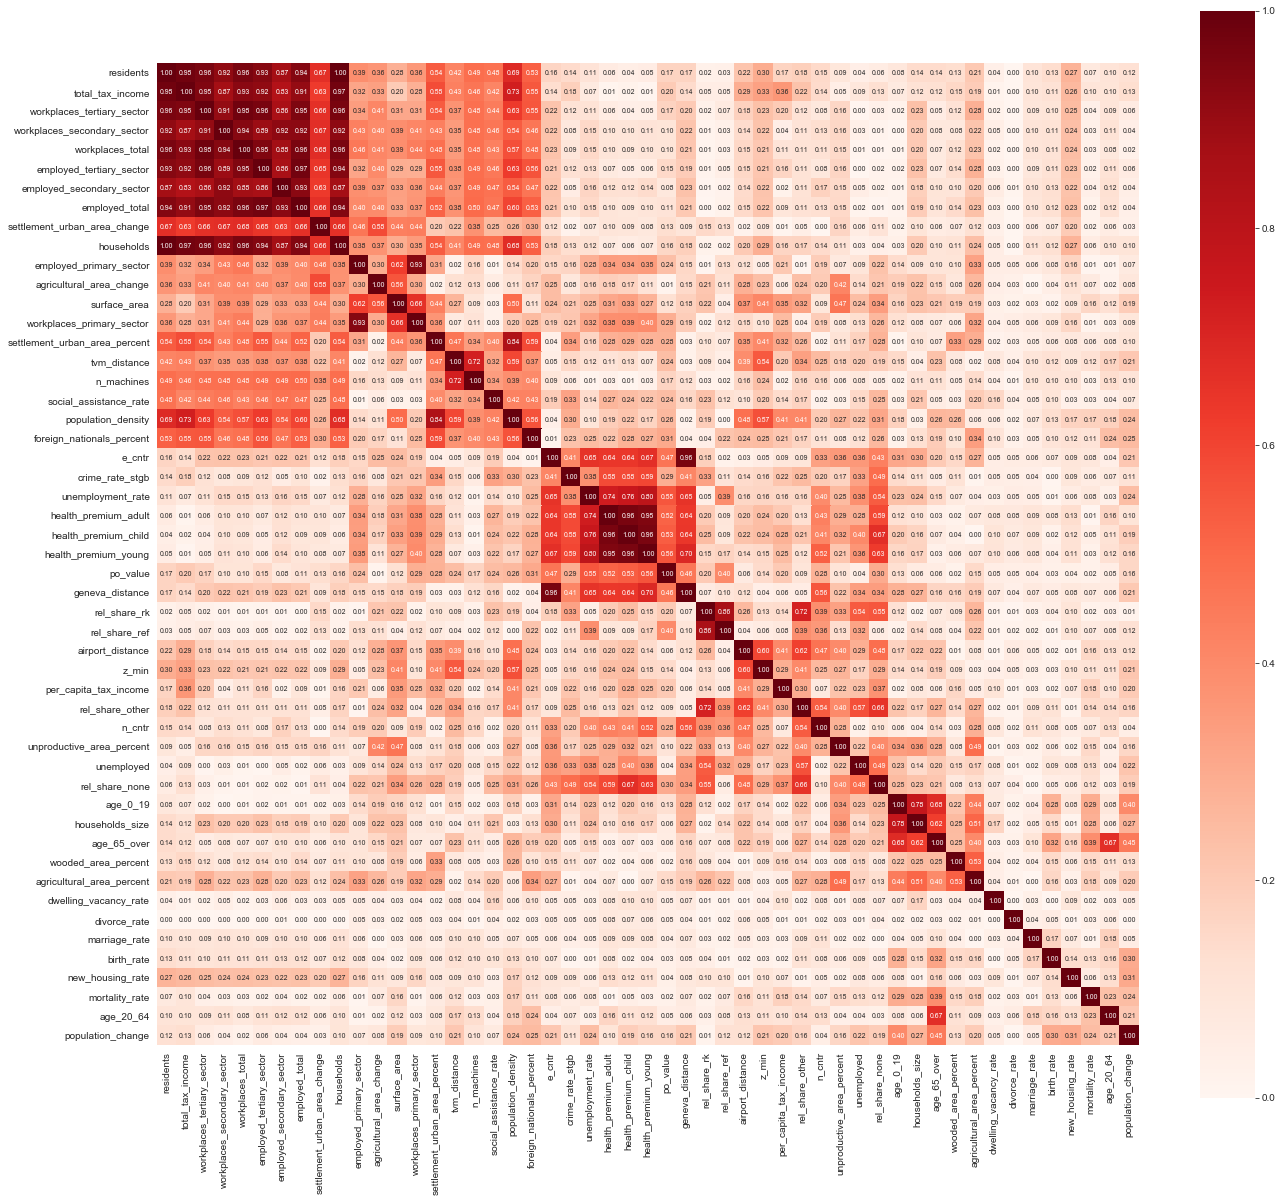

In [8]:
# https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python
# https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb

from scipy.cluster import hierarchy
from scipy.spatial import distance

pdist = distance.pdist(df2.corr().abs().values) # pairwise distances, shape (1275,) (51*50/2)
linkage = hierarchy.linkage(pdist, method="ward")
cluster_idx = hierarchy.fcluster(linkage, 0.5 * pdist.max(), 'distance') # shape (51,)
clustered_cols = df2.columns[np.argsort(cluster_idx)]
clustered_corr = df2[clustered_cols].corr().abs()

plt.figure(figsize = (22,20))
sns.heatmap(clustered_corr, annot = True, fmt = '.2f',
            square=True, vmin = 0, vmax = 1, cmap= 'Reds', annot_kws = {"fontsize":"x-small"}); # mask = np.triu(corr), 

In [9]:
print("{} clusters".format(cluster_idx.max()))
clusters = collections.defaultdict(list)
for x in zip(cluster_idx, df2.columns):
    clusters[x[0]].append(x[1])
for it in sorted(clusters.items()):
    print(it)

11 clusters
(1, ['residents', 'households', 'settlement_urban_area_change', 'employed_total', 'employed_secondary_sector', 'employed_tertiary_sector', 'workplaces_total', 'workplaces_secondary_sector', 'workplaces_tertiary_sector', 'total_tax_income'])
(2, ['surface_area', 'agricultural_area_change', 'employed_primary_sector', 'workplaces_primary_sector'])
(3, ['population_density', 'foreign_nationals_percent', 'settlement_urban_area_percent', 'social_assistance_rate', 'n_machines', 'tvm_distance'])
(4, ['health_premium_child', 'health_premium_young', 'health_premium_adult', 'unemployment_rate', 'crime_rate_stgb', 'e_cntr', 'geneva_distance', 'po_value'])
(5, ['rel_share_rk', 'rel_share_ref'])
(6, ['rel_share_other', 'per_capita_tax_income', 'z_min', 'airport_distance'])
(7, ['unproductive_area_percent', 'rel_share_none', 'unemployed', 'n_cntr'])
(8, ['age_0_19', 'age_65_over', 'households_size'])
(9, ['agricultural_area_percent', 'wooded_area_percent'])
(10, ['divorce_rate', 'dwelling

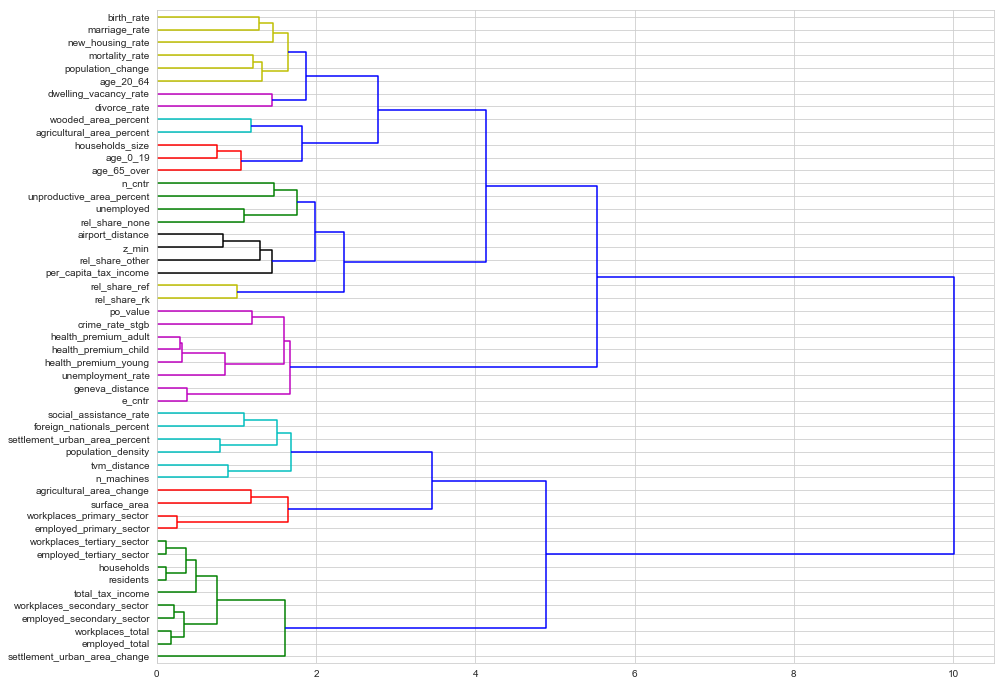

In [10]:
plt.figure(figsize = (15,12))
hierarchy.dendrogram(linkage, labels=df2.columns, color_threshold=0.5 * pdist.max(),
                     orientation="right", leaf_font_size="medium");

### Correlation of categorical to numerical variables
I use the **correlation ratio** $\eta$ (eta) [(Wikipedia)](https://en.wikipedia.org/wiki/Correlation_ratio) to measure the relationship between the categorical variables (canton, language, typology) and the other variables, which are numerical (including the target). $\eta$ takes values between 0 and 1. $\eta = 0$ is the extreme case where the mean is the same for all categories (the category cannot help to explain the other variable), and $\eta = 1$ is the other extreme case where there is no variance inside of the categories, i.e. the category of a variable can fully predict its value.

Reference: Shaked Zychlinski, "The Search for Categorical Correlation", https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [11]:
# source: Shaked Zychlinski: "The Search for Categorical Correlation"
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://github.com/shakedzy/dython
def shakeds_correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(round(numerator / denominator, 12)) # rounding and sqrt added by me
    return eta

In [12]:
# I panda-fied Shaked Zychlinski's function and also apply the square root to the result
def correlation_ratio(data, category_col, measurement_col):
    grouped = data.groupby(by=category_col)
    # mean of items in category (was y_avg_array)
    group_means = grouped[measurement_col].mean()
    # number of items in category (was n_array)
    group_size = grouped.size() 
    # total number of values (was np.sum(n_array))
    total_size = grouped.size().sum()
    # overall weighted mean (was y_total_avg)
    total_mean = (group_means * group_size).sum() / total_size
    
    numerator = (group_size * (group_means - total_mean)**2).sum()
    denominator = ((data[measurement_col] - total_mean)**2).sum()
    if numerator == 0:
        return 0.0
    else:
        return math.sqrt(round(numerator / denominator, 12)) # rounding and sqrt added by me

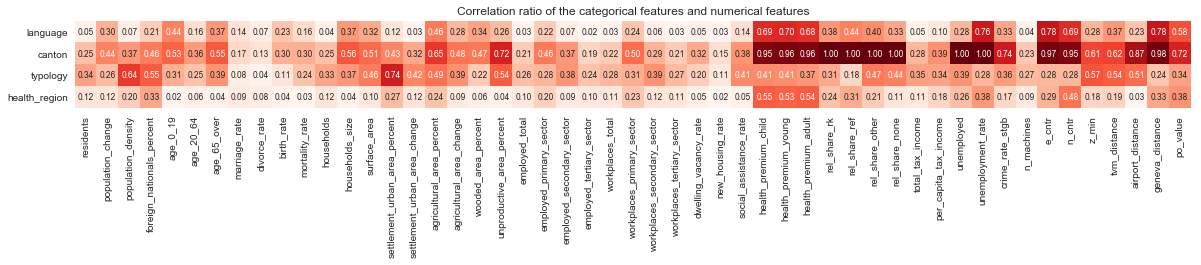

In [13]:
correlation_ratios = {}
other_features = [it for it in df.columns if it not in categorical_features]
other_features.remove("po_value")
other_features.append("po_value") # put it at the end
# other_features = ["employed_total"]
for cat in categorical_features:
    correlation_ratios[cat] = []
    for var in other_features:
        correlation_ratios[cat].append(correlation_ratio(df, cat, var))
        # print (cat, var, correlation_ratio(df, cat, var))
        # his_cr = shakeds_correlation_ratio(df[cat].values, df[var].values)
        #my_cr = correlation_ratio(df, cat, var)
        # print (cat, var, my_cr, his_cr, np.abs(my_cr - his_cr), flush=True)
        # assert (my_cr - his_cr < 1e-12), 'my_cr his_cr differ'
        # assert (my_cr <= 1 and his_cr <= 1), ' not <= 1'
        
df_correlation_ratios = pd.DataFrame.from_dict(correlation_ratios)
df_correlation_ratios.index = other_features

plt.figure(figsize=(20,5))
sns.heatmap(df_correlation_ratios.transpose(), square=True, annot = True, fmt = '.2f',
            annot_kws = {"fontsize":"small"}, cmap= 'Reds', cbar=False)
plt.title("Correlation ratio of the categorical features and numerical features")
plt.show()

### Correlation of categorical variables
Correlation (or correlation ratio) cannot be used to measure the association between two categorical variables. I use the **uncertainty coefficient**, or Theil's U [(Wikipedia)](https://en.wikipedia.org/wiki/Uncertainty_coefficient) instead. It is based on information entropy and tells us, knowing one variable, how many bits of the other variable can be predicted. Again, the range is 0 to 1, with 0 meaning no association and 1 meaning the other variable can be fully predicted. Note that this function is not symmetrical.

Reference: Shaked Zychlinski, "The Search for Categorical Correlation", https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [14]:
# source: Shaked Zychlinski: "The Search for Categorical Correlation"
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://github.com/shakedzy/dython
from collections import Counter
import scipy.stats as ss

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    #  given Y, what fraction of the bits of X can we predict?
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

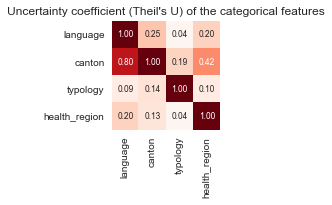

y-axis given, x-axis predict


In [15]:
theils_us = {}
for x in categorical_features:
    theils_us[x] = []
    for y in categorical_features:
        theils_us[x].append(theils_u(df[x], df[y]))

df_theils_us = pd.DataFrame.from_dict(theils_us)
df_theils_us.index = categorical_features

plt.figure(figsize=(2 ,2))
sns.heatmap(df_theils_us, square=True, annot = True, fmt = '.2f',
            annot_kws = {"fontsize":"small"}, cmap= 'Reds', cbar=False)
plt.title("Uncertainty coefficient (Theil's U) of the categorical features")
plt.show()
print("y-axis given, x-axis predict")

## Scatterplots

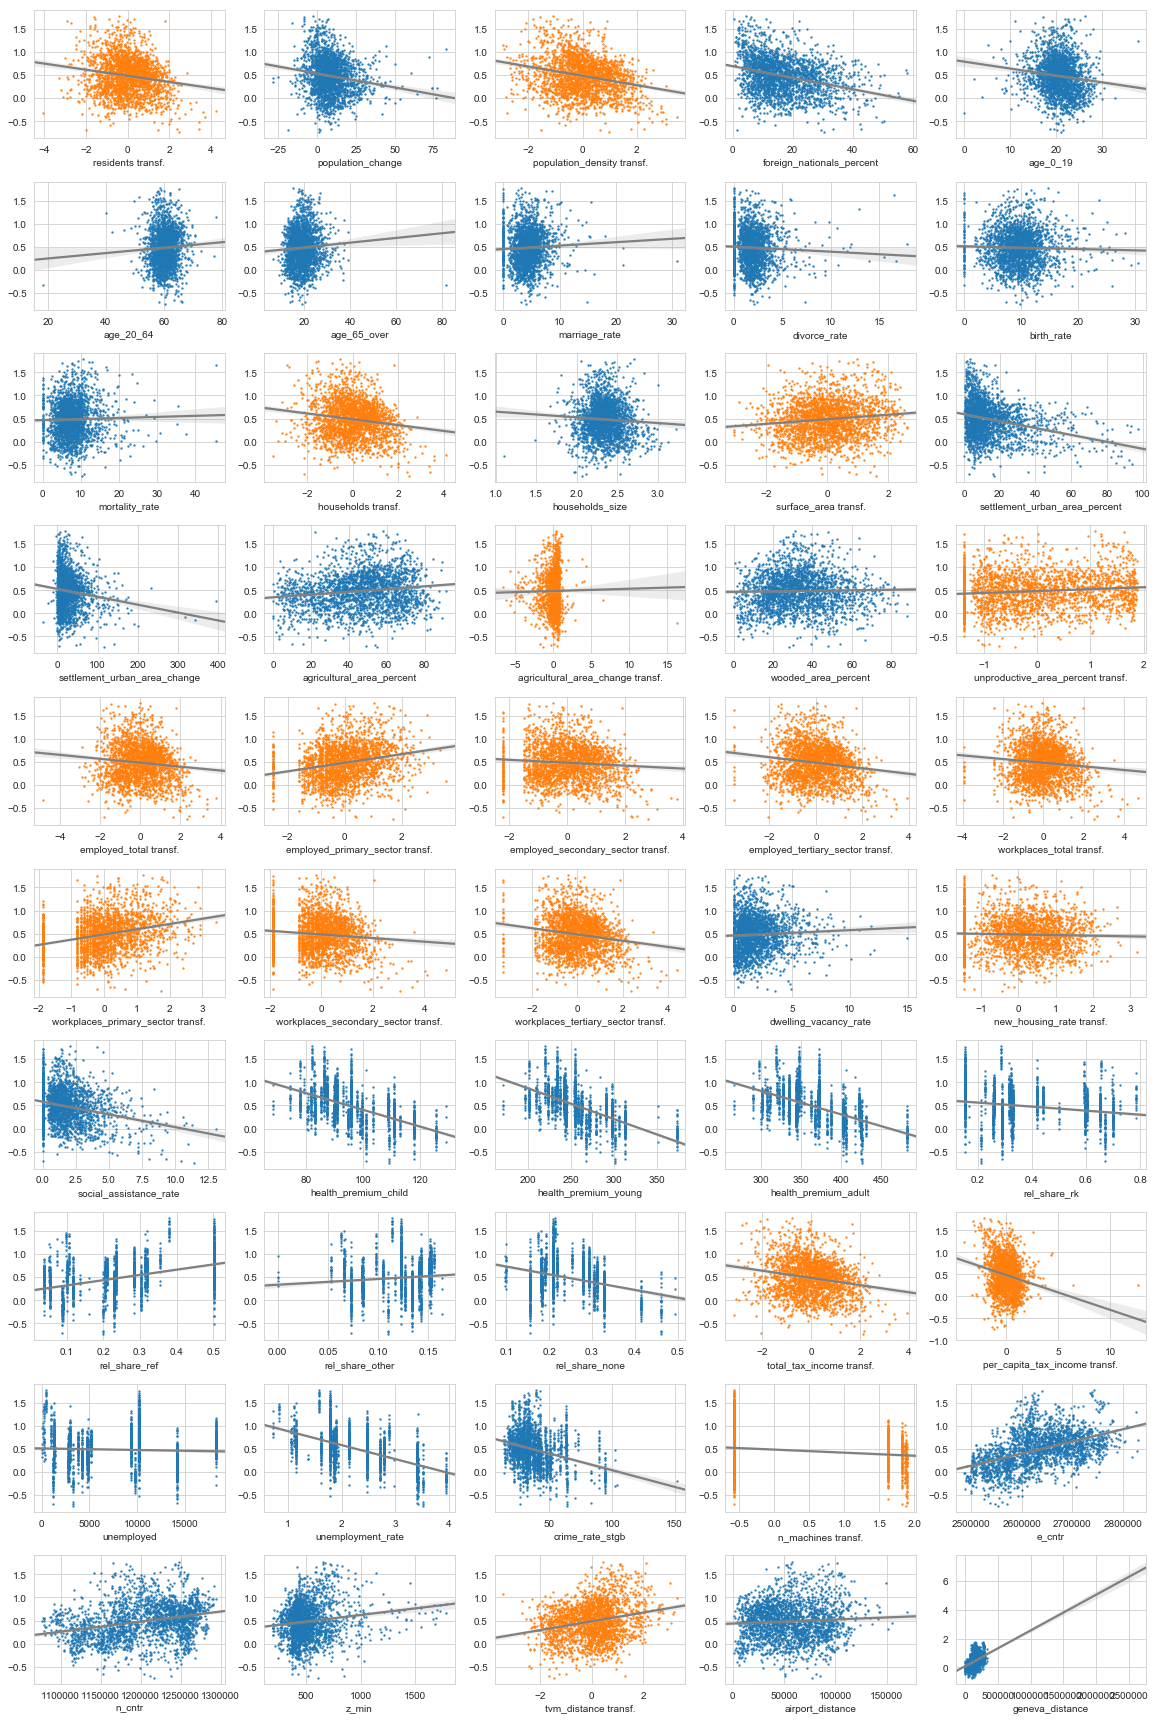

In [16]:
cols = [col for col in df.columns if col not in categorical_features and col != "po_value"]
pt = PowerTransformer()
fig, axs = plt.subplots(10, 5, figsize = (16, 24))
for i, ax in enumerate(axs.flatten()):
    if i < len(cols):
#    if i < 3:
        if cols[i] in unskewed_features:
            sns.regplot(x=df[cols[i]], y=df["po_value"], ax = ax, scatter_kws={'s': 2, "color": color_0}, line_kws={"color": "grey"})
            ax.set_ylabel("")
        else:
            x = pt.fit_transform(df[cols[i]].values.reshape(-1, 1))
            sns.regplot(x=x.reshape(-1), y=df["po_value"], ax = ax, scatter_kws={'s': 2, "color": color_1}, line_kws={"color": "grey"})
            ax.set_xlabel(cols[i] + " transf.")
            ax.set_ylabel("")
    else:
        ax.set_axis_off()
plt.tight_layout()